# Загрузка данных

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime as dt

In [46]:
# Загрузка данных
df = pd.read_csv('to-modal.csv', parse_dates=['dt'], index_col='dt')


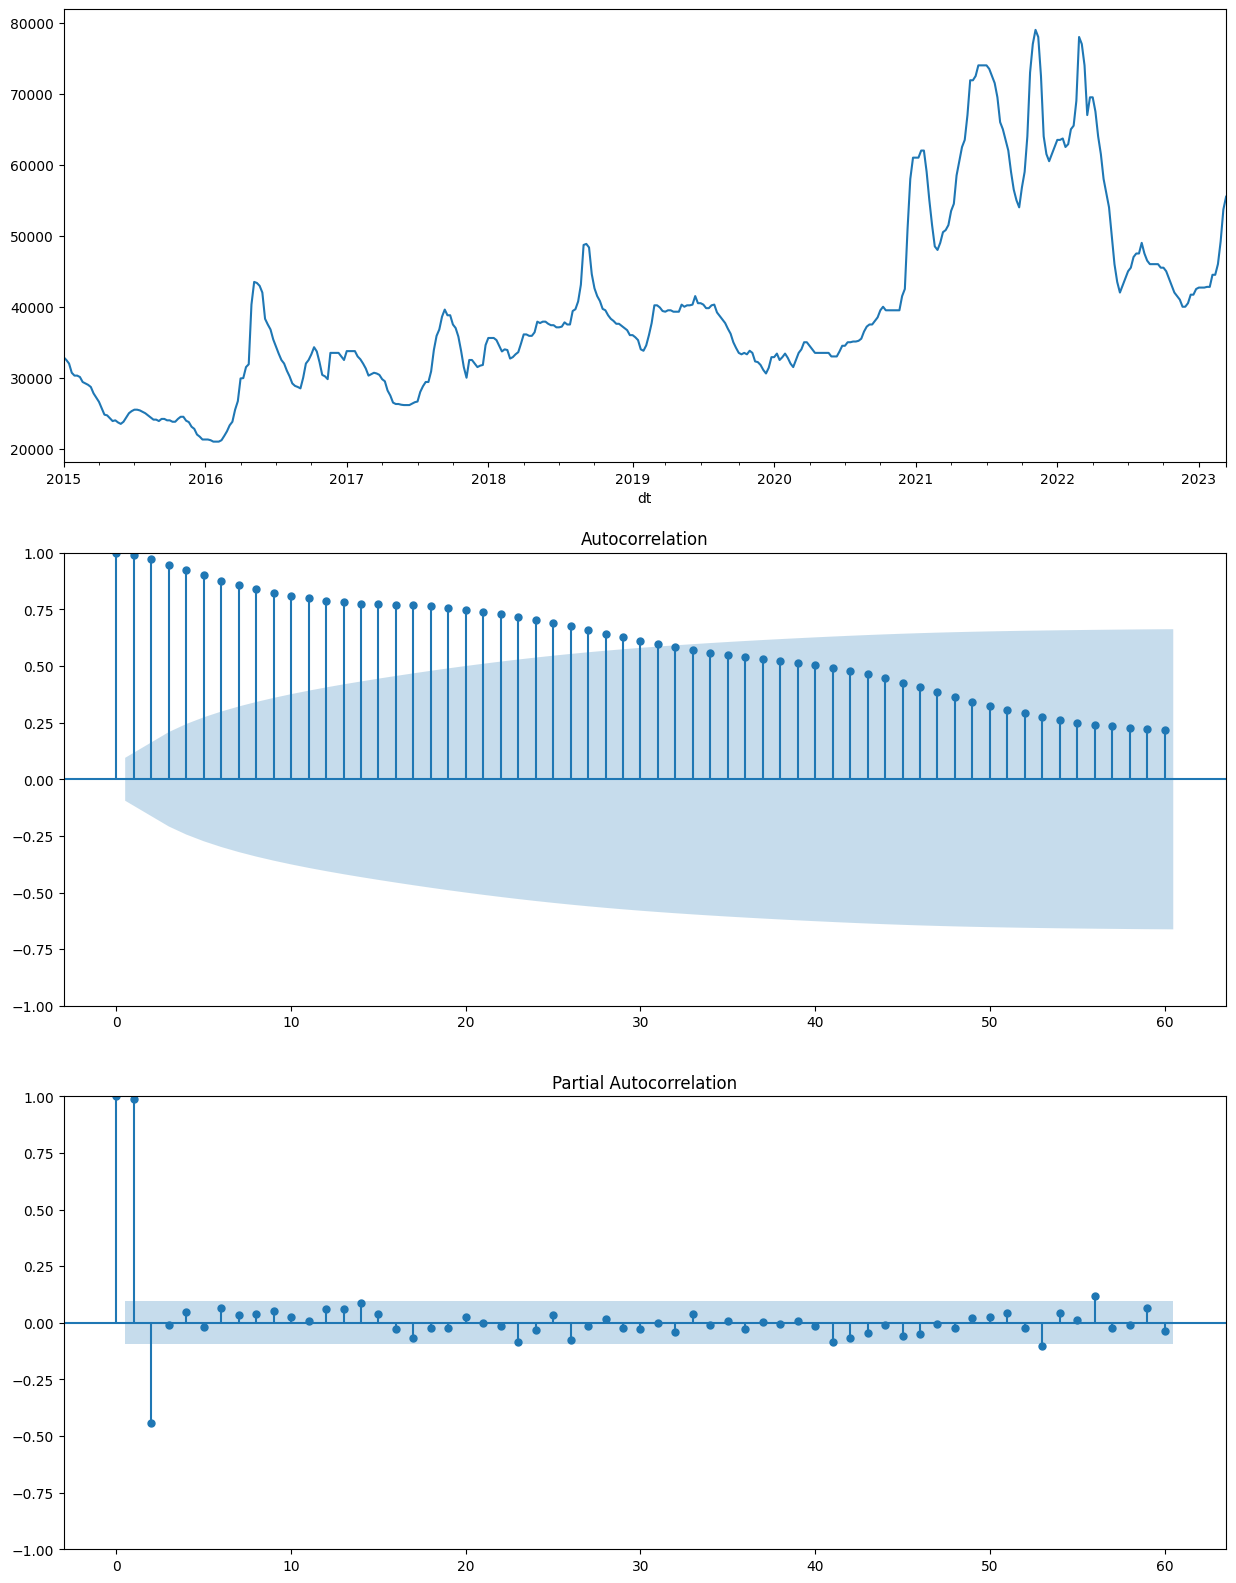

In [47]:
# вывод кореллограмм и ? (аргументировать зачем)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df['Цена на арматуру'], lags=60, ax=ax[2]);

In [48]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = df.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

# Модели

## catboost

In [49]:
from catboost import CatBoostRegressor

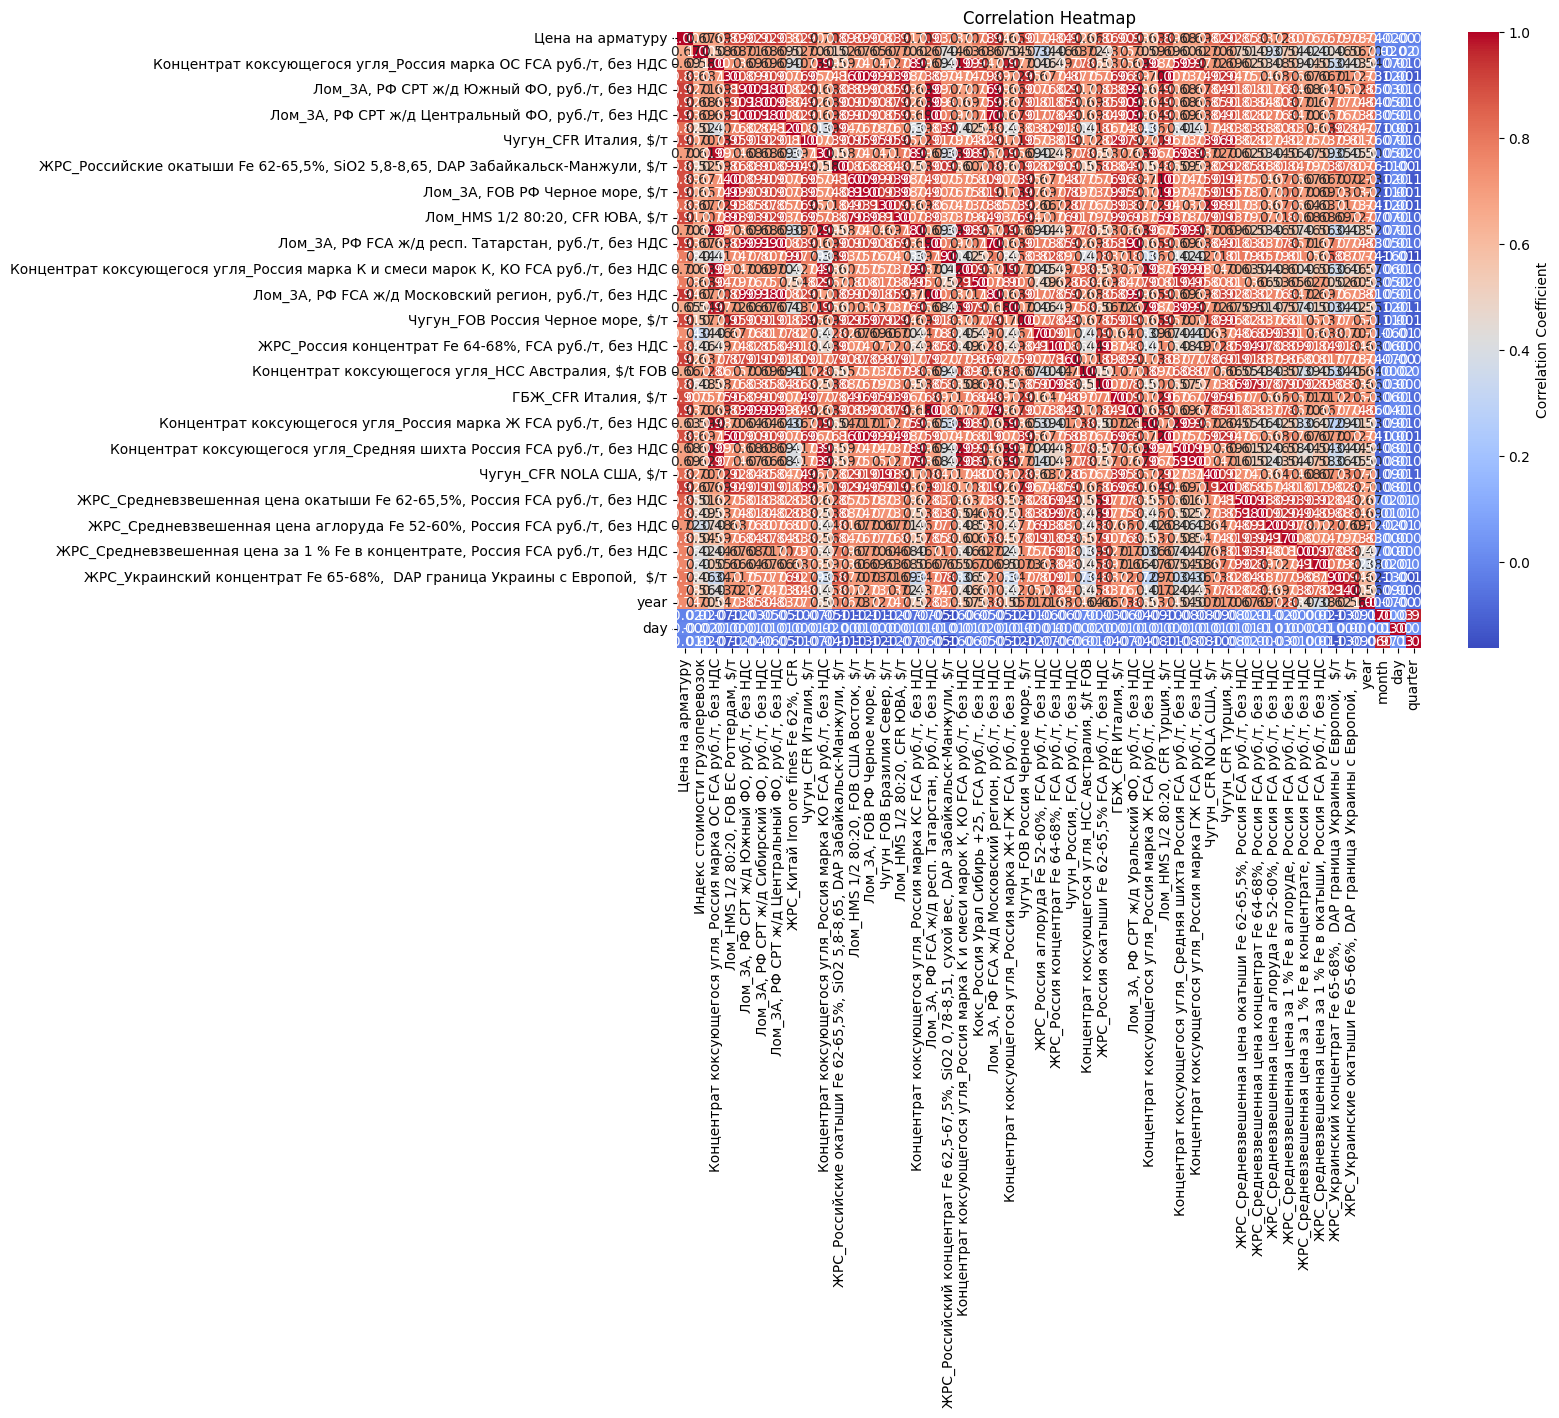

In [50]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Heatmap')
plt.show()

In [51]:
# Выбор признаков и целевой переменной
features = ['year', 'month', 'day', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_12', 'rolling_std', 'normalized_price', 'log_normalized_price']
target = 'diff_log'

# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train.drop(columns=['Цена на арматуру']), train['Цена на арматуру']
X_test, y_test = test.drop(columns=['Цена на арматуру']), test['Цена на арматуру']

for lag in [1, 2, 3, 6, 12]:
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

C:\Users\Илья\AppData\Local\Temp\ipykernel_22260\2512482259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)
C:\Users\Илья\AppData\Local\Temp\ipykernel_22260\2512482259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)
C:\Users\Илья\AppData\Local\Temp\ipykernel_22260\2512482259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [63]:
# Создание и обучение модели
model = CatBoostRegressor(iterations=10000, 
                          learning_rate=0.05, 
                          depth=6, 
                          loss_function='MAE',
                          verbose=200,
                          has_time=True)

model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=200)

# Прогнозирование
predictions = model.predict(X_test)

0:	learn: 6429.2660767	test: 20561.1627798	best: 20561.1627798 (0)	total: 8.87ms	remaining: 1m 28s
200:	learn: 574.7130151	test: 5354.1228660	best: 5354.1228660 (200)	total: 754ms	remaining: 36.7s
400:	learn: 303.9233410	test: 5383.8284356	best: 5336.5584277 (272)	total: 1.3s	remaining: 31.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5336.558428
bestIteration = 272

Shrink model to first 273 iterations.


In [64]:
predictions

array([68915.48492204, 68349.68146858, 66579.84522641, 65372.03921269,
       62574.07028027, 61222.75972712, 60761.43912995, 60679.6482757 ,
       60746.39491026, 60735.65757647, 58969.55463621, 57412.13412242,
       58622.08708985, 60132.32357648, 60178.26924934, 59732.74490257,
       59570.15454897, 59565.52668303, 52927.65358003, 51819.39247841,
       52423.8234927 , 53461.38278715, 53885.82739036, 56091.03858071,
       56453.08515864, 57317.25001476, 57115.93265827, 57553.12016759,
       59946.63416524, 61189.52271318, 63505.70822099, 66036.57310772,
       68310.4217381 , 68608.85257019, 68632.76127497, 67122.93193317,
       66762.55756796, 66629.3387067 , 67579.06436405, 69530.35176188,
       67641.22339178, 67030.94148612, 65416.45304606, 64273.7040895 ,
       59918.50365003, 57075.02812988, 55255.44468014, 53287.22748838,
       46112.41224119, 45754.69805225, 42816.86321419, 45744.52714104,
       46244.71126933, 43523.64111155, 42124.94016014, 42172.29799032,
      

In [66]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 5336.56
MSE: 47857088.80
RMSE: 6917.88
R²: 0.6348


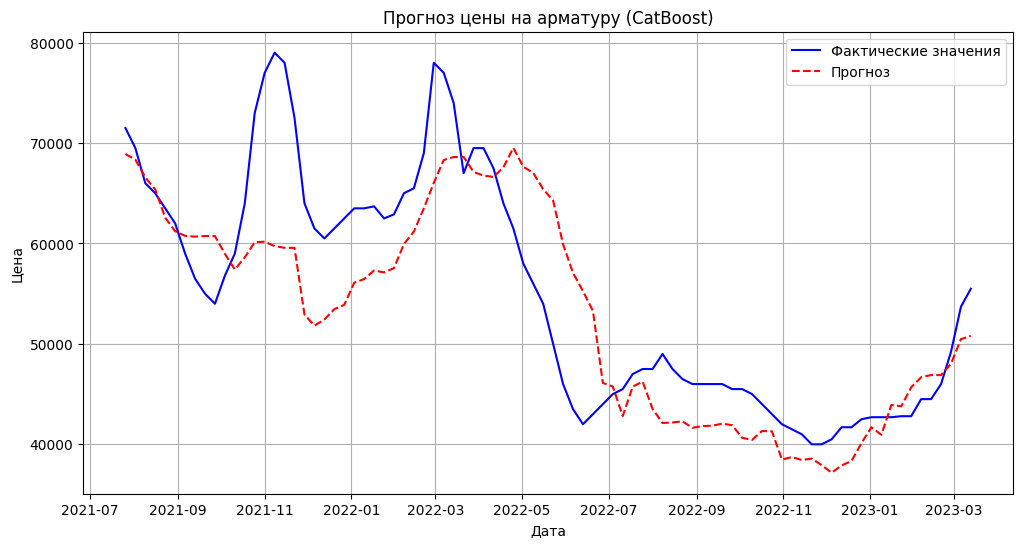

In [67]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (CatBoost)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Получаем важность признаков из модели
feature_importance = model.feature_importances_

# Сортируем индексы по убыванию важности
sorted_idx = np.argsort(feature_importance)[::-1]

# Выбираем топ-15 индексов
top_n = 10
top_feature_indices = sorted_idx[:top_n]

# Если исходный датасет — pandas.DataFrame
if isinstance(X_train, pd.DataFrame):
    # Получаем имена топ-признаков
    top_features = X_train.columns[top_feature_indices].tolist()
    # Создаем новый датасет с отобранными признаками
    X_selected = X_train[top_features]

# Если исходный датасет — numpy.ndarray
else:
    # Создаем новый датасет, выбирая столбцы по индексам
    X_selected = X_train[:, top_feature_indices]

print("Топ-15 признаков:", top_feature_indices)
X_selected

Топ-15 признаков: [10 32 26 15  4  7 25 34 46 36]


,"Лом_HMS 1/2 80:20, FOB США Восток, $/т","Концентрат коксующегося угля_Россия марка ГЖ FCA руб./т, без НДС","ЖРС_Россия окатыши Fe 62-65,5% FCA руб./т, без НДС","Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_HCC Австралия, $/t FOB","Чугун_CFR Турция, $/т",quarter,"ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС"
dt,,,,,,,,,,
2015-01-05,221.0,3350.0,3450.0,11573.0,10009.0,285.5,106.0,297.5,1,2097.0
2015-01-12,221.0,3350.0,3450.0,11573.0,10009.0,285.5,106.0,297.5,1,2097.0
2015-01-19,221.0,3350.0,3450.0,11573.0,10009.0,285.5,106.0,297.5,1,2097.0
2015-01-26,221.0,3350.0,3450.0,11573.0,10009.0,285.5,106.0,297.5,1,2097.0
2015-02-02,221.0,3350.0,3450.0,11573.0,10009.0,285.5,106.0,297.5,1,2097.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-21,461.0,6650.0,16750.0,28202.0,27722.0,661.5,201.0,658.0,2,10279.0
2021-06-28,459.0,6650.0,16750.0,27807.0,26673.0,655.0,211.0,652.5,2,12288.0
2021-07-05,459.0,9500.0,16450.0,26924.0,25813.0,660.0,220.0,670.0,3,12288.0


In [69]:
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=100)

0:	learn: 6429.2660767	test: 20561.1627798	best: 20561.1627798 (0)	total: 6.76ms	remaining: 1m 7s
200:	learn: 574.7130151	test: 5354.1228660	best: 5354.1228660 (200)	total: 755ms	remaining: 36.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5336.558428
bestIteration = 272

Shrink model to first 273 iterations.


In [70]:
predictions = model.predict(X_test)

In [71]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 5336.56
MSE: 47857088.80
RMSE: 6917.88
R²: 0.6348
